## Model #1

This model is based on control group - people not previously affected by campaign.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2020)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('bank_data_prediction_task.csv', index_col=0)
df['y'] = df['y'].map(lambda x: 1 if x=='yes' else 0) 

In [3]:
df_cont = df[df['test_control_flag']=='control group']
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24712 entries, 16477 to 41188
Data columns (total 22 columns):
age                  24712 non-null int64
job                  24712 non-null object
marital              24712 non-null object
education            24712 non-null object
default              24712 non-null object
housing              24712 non-null object
loan                 24712 non-null object
contact              0 non-null object
month                0 non-null object
day_of_week          0 non-null object
duration             0 non-null float64
campaign             0 non-null float64
pdays                24712 non-null int64
previous             24712 non-null int64
poutcome             24712 non-null object
emp.var.rate         24712 non-null float64
cons.price.idx       24599 non-null float64
cons.conf.idx        24712 non-null float64
euribor3m            24712 non-null float64
nr.employed          24712 non-null float64
y                    24712 non-null int64
t

In [4]:
df_cont.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag
18340,29,services,married,high.school,no,yes,no,NaN,NaN,NaN,NaN,NaN,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,control group
20913,55,unknown,married,unknown,unknown,no,no,NaN,NaN,NaN,NaN,NaN,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,0,control group
23919,33,self-employed,married,basic.9y,no,yes,no,NaN,NaN,NaN,NaN,NaN,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0,control group
24601,33,blue-collar,single,basic.6y,no,no,no,NaN,NaN,NaN,NaN,NaN,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,1,control group
39076,73,retired,married,basic.4y,unknown,no,no,NaN,NaN,NaN,NaN,NaN,999,0,nonexistent,-2.9,92.201,-31.4,0.854,5076.2,0,control group


In [4]:
camp_col = ['contact', 'month', 'day_of_week', 'duration', 'campaign',  
            'previous', 'poutcome', 'test_control_flag', 'pdays']

df_cont = df_cont.loc[:, df_cont.columns.isin(camp_col)==False].reset_index()
del df_cont['index']

In [5]:
df_cont.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
emp.var.rate      False
cons.price.idx     True
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [8]:
len(df_cont[df_cont['cons.price.idx'].isnull()==True])

113

In [6]:
cons_price_med = df_cont['cons.price.idx'].median()
df_cont['cons.price.idx'] = df_cont['cons.price.idx'].fillna(cons_price_med)

Due to fact that there is only 113 missing value for only one feature, I've decided to replace it with median of consumer price index.

In [12]:
df_cont.isnull().any().any()

False

In [7]:
def feat_eng(df):    
    """Function transforming input dataframe by adding new columns and modifing existing. 
    df -- dataframe to transform
    """
    
    basic = ['basic.9y', 'basic.6y', 'basic.4y']
    df['education'] = df['education'].map(lambda x: 'basic' if x in(basic) else x)
    
    cat_feats = ['job', 'marital', 'education']
    for cat_feat in cat_feats:
        df['{0}_cat'.format(cat_feat)] = pd.factorize(df[cat_feat])[0]
        
    map_feat = ['default', 'housing', 'loan']
    for f in map_feat:
        df[f] = df[f].apply(
        lambda x: 1 if x == 'yes' else 0 if x=='no' else -1)
        
    df['young'] = df['age'].apply(lambda x: 1 if x < 23 else 0 )
    df['old'] = df['age'].apply(lambda x: 1 if x >= 60 else 0 )
    df['student'] = df['job'].apply(lambda x: 1 if x=='student' else 0 )
    df['retir'] = df['job'].apply(lambda x: 1 if x=='retired' else 0 )
    df['minus_rate'] = df['emp.var.rate'].apply(lambda x: 1 if x < 0 else 0 )
    
    return df

In [8]:
df_cont_ = feat_eng(df_cont)

In [15]:
df_cont_.sample(5)

,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_cat,marital_cat,education_cat,young,old,student,retir,minus_rate
13443,41,housemaid,married,university.degree,0,1,0,1.4,93.444,-36.1,4.963,5228.1,0,0,0,4,0,0,0,0,0
6197,56,blue-collar,single,basic,-1,0,0,1.4,94.465,-41.8,4.960,5228.1,0,3,1,0,0,0,0,0,0
9102,58,retired,married,high.school,0,1,0,1.4,93.918,-42.7,4.958,5228.1,0,7,0,1,0,0,0,1,0
19434,47,services,married,high.school,0,0,1,-1.8,92.893,-46.2,1.313,5099.1,0,1,0,1,0,0,0,0,1
2768,40,admin.,married,university.degree,0,0,0,1.1,93.994,-36.4,4.858,5191.0,0,2,0,4,0,0,0,0,0


As a result of transformations new features have been created. Furthermore, categorical values have been replaced by numeric. In case of education, categories for basic education have been aggregated into one bucket.

After number of experiments I've choosen only subset of features:

In [9]:
features = ['age','default', 'housing', 'loan', 'euribor3m',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
            'job_cat', 'marital_cat', 'education_cat']

X_cv = df_cont_.loc[:, features]
y_cv = df_cont_.loc[:, 'y']

Cross validation have been prepared to assure proper validation and calculation of success metrics.

In [10]:
def my_cv (m, x, y): 
    """Function performs cross validation and calculates mean of success metrics: 
    precision, recall and f1.   
    m -- model to test
    X -- features to fit model
    y -- target variable
    """
    cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
    scores_r = []
    scores_p = []
    scores_f = []
    
    for train_idx, test_idx in cv.split(x,y):  
        model = m 
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict(x.loc[test_idx])  
        
        score1 = recall_score(y[test_idx], y_pred)
        score2 = precision_score(y[test_idx], y_pred)
        score3 = f1_score(y[test_idx], y_pred)
        
        scores_r.append(score1)
        scores_p.append(score2)
        scores_f.append(score3)     
        
    return round(np.mean(scores_r),3), round(np.mean(scores_p),3), round(np.mean(scores_f),3)

I've verified performance of solution with the use of few models with some regularization added.

In [19]:
models = [DummyClassifier(random_state=2020),
          LogisticRegression(random_state=2020),
          RandomForestClassifier(random_state=2020, max_depth=6),
          GradientBoostingClassifier(random_state=2020, max_depth=5),
          xgb.XGBClassifier(random_state=2020, max_depth=5, n_estimators=100)]

print('     Model      ''\t'' (recall, precision, f1)')
for m in models:
    print(type(m).__name__, '\t', my_cv(m, X_cv, y_cv))

     Model      	 (recall, precision, f1)
DummyClassifier 	 (0.098, 0.102, 0.1)
LogisticRegression 	 (0.0, 0.0, 0.0)
RandomForestClassifier 	 (0.027, 0.462, 0.05)
GradientBoostingClassifier 	 (0.126, 0.483, 0.2)
XGBClassifier 	 (0.078, 0.461, 0.134)


All models have small recall, they have problems with detect all potential clients. Level of recall is comparable with dummy classifier, what is of course not satisfactioning. However, models have about 40-50% of precision what is much better than in case of dummy model.

In further analysis I've choosen GradientBoostingClassifier as a classificator with best f1 score. In my opinion in this task f1 is an optimal success metric. Compromise between precision and recall seems to be important. Budget is limited so there is no place to call to many people with low probability of subscrbing. Furthermore, we want to identity clients precisely, it is not reasonable to offer term deposit to people which are for example in poor financial condition.

Some hyperparameters have been found using hyperopt. Results of searching are available [here](#hyp).

#### Final model:

In [20]:
m = GradientBoostingClassifier(max_depth=5, n_estimators=100, min_samples_split=2,
                               learning_rate=0.19962839911665375, random_state=2020)

In [21]:
my_cv(m, X_cv, y_cv)

(0.162, 0.441, 0.236)

F1 is higher than before. Recall has increased in about 4%. 

### Learning curves

In [22]:
def plot_learning_curve(estimator, X, y, score='f1', ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.5, 1.0, 6)):
    plt.figure(figsize=(15, 5))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes, scoring=score)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title(type(estimator).__name__)
    plt.legend(loc="best")
    return plt

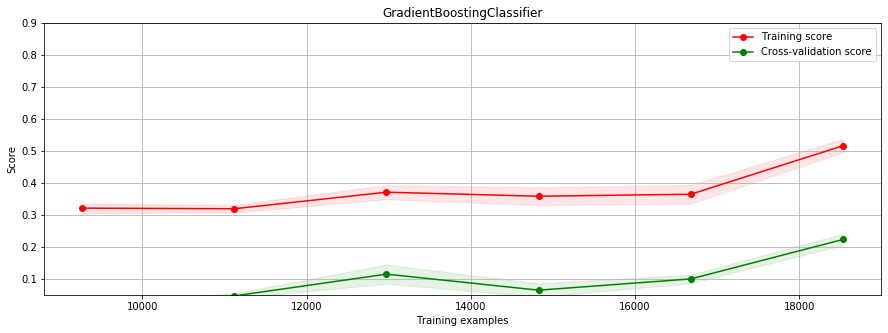

In [23]:
cv = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
plot_learning_curve(m, X_cv, y_cv, ylim=(0.05, 0.9), cv=cv);

Learning curves show that model is unfortunately overfitted. Better hyperparameter optimization or adding more data could be helpful.

### Precision - recall curves

In [24]:
def plot_precision_vs_recall(precisions, recalls):    
    plt.plot(recalls, precisions, "b-", linewidth=2)    
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)   
    plt.axis([0, 1, 0, 1])

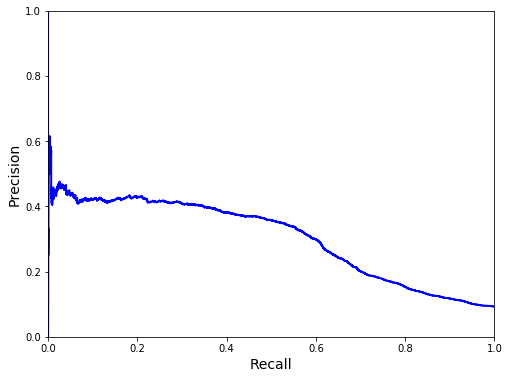

In [25]:
cv = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
y_predict = cross_val_predict(m, X_cv, y_cv, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]   
precisions, recalls,thresholds = precision_recall_curve(y_cv, y_pred) 
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):   
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)    
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(loc="down right", fontsize=10)

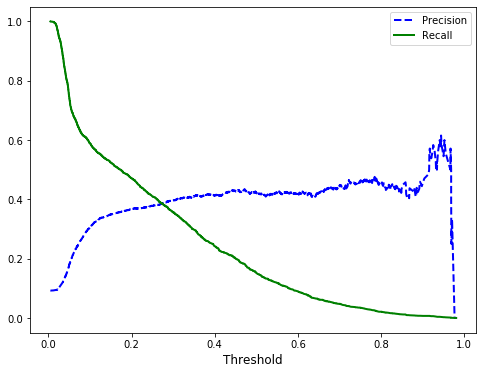

In [27]:
cv = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
y_predict = cross_val_predict(m, X_cv, y_cv, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]
precisions, recalls, thresholds = precision_recall_curve(y_cv, y_pred)  
    
plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Precision recall curves give evidences that performance of model can change using different threshold in classification algorithms.
Default threshold is 0.5. Changing it below 0.3 results in much higher recall with about 5% decrease in precision.

### ROC curve

In [28]:
def plot_roc_curve(fpr, tpr, label=None):     
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')   
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('False positive rate', fontsize=13)
    plt.ylabel('True positive rate', fontsize=13)

roc auc score: 77.04%


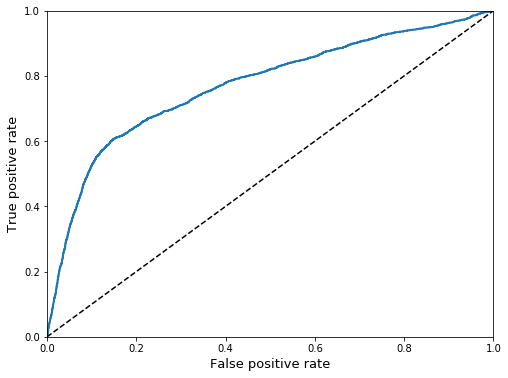

In [29]:
cv = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
y_predict = cross_val_predict(m, X_cv, y_cv, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]    
fpr, tpr, thresholds = roc_curve(y_cv, y_pred) 
    
plt.figure(figsize=(8, 6))
print('roc auc score: {}%'.format(round(roc_auc_score(y_cv, y_pred)*100,2)))    
plot_roc_curve(fpr, tpr)
plt.show()

ROC curve shows that model is not ideal. When level of recall is higher than 60%, rate of false positive increases much faster.

### Threshold modification

In [30]:
def train_and_predict(model, X, y, test_size=0.3, threshold=0.5, matrix=False):   
    
    """Function splits data into train, test set, calculates probabilities based on given threshold and 
    success metrics.
    model -- model to test
    X -- features to fit model
    y -- target variable
    test_size -- proportions how to split data into train and test
    threshold -- probability used to make decision
    matrix -- boolean flag used to print confusion matrix
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020) 

    model.fit(X_train, y_train)    
    y_pred = model.predict_proba(X_test)[:,-1] 
    y_pred_ = np.where(y_pred >= threshold, 1, 0)
        
    prec = np.round(precision_score(y_test, y_pred_),3)
    recc = np.round(recall_score(y_test, y_pred_),3)
    f1 = np.round(f1_score(y_test, y_pred_),3)
    
    if matrix==True:
        print('confusion matrix','\n',confusion_matrix(y_test, y_pred_))
        
    print('recall, precision, f1')  
    
    return recc, prec, f1

In [31]:
m = GradientBoostingClassifier(max_depth=5, n_estimators=100, min_samples_split=2,
                               learning_rate=0.19962839911665375, random_state=2020)

In [32]:
train_and_predict(model=m, X=X_cv, y=y_cv, test_size=0.3, threshold=0.5, matrix=True)

confusion matrix 
 [[6592  116]
 [ 613   93]]
recall, precision, f1


(0.132, 0.445, 0.203)

In [33]:
train_and_predict(model=m, X=X_cv, y=y_cv, test_size=0.3, threshold=0.3, matrix=True)

confusion matrix 
 [[6366  342]
 [ 487  219]]
recall, precision, f1


(0.31, 0.39, 0.346)

In [34]:
train_and_predict(model=m, X=X_cv, y=y_cv, test_size=0.3, threshold=0.25, matrix=True)

confusion matrix 
 [[6272  436]
 [ 442  264]]
recall, precision, f1


(0.374, 0.377, 0.376)

Manipulating of threshold allows to get different values of success metrics. Changing threshold to 0.25 may be in this case reasonable. Precision and recall are on the same level (37%). We dont't take into consideration clients with lowest probabilities, others are potentially interesting.

### Feature importances

In [35]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

Using TensorFlow backend.


In [36]:
model = GradientBoostingClassifier(max_depth=5, n_estimators=100, min_samples_split=2,
                                   learning_rate=0.19962839911665375, random_state=2020)

In [37]:
model.fit(X_cv, y_cv)
imp = PermutationImportance(model, random_state=2020).fit(X_cv, y_cv)

In [38]:
eli5.show_weights(imp, feature_names=features)

Weight,Feature
0.0719 ± 0.0018,emp.var.rate
0.0458 ± 0.0022,euribor3m
0.0197 ± 0.0014,age
0.0157 ± 0.0007,cons.price.idx
0.0130 ± 0.0010,cons.conf.idx
0.0090 ± 0.0011,job_cat
0.0062 ± 0.0004,education_cat
0.0032 ± 0.0004,default
0.0029 ± 0.0004,loan
0.0024 ± 0.0005,housing


In [39]:
eli5.show_weights(model, feature_names=features)

Weight,Feature
0.5059 ± 0.2901,euribor3m
0.1636 ± 0.2554,age
0.0614 ± 0.1137,cons.conf.idx
0.0560 ± 0.1342,emp.var.rate
0.0542 ± 0.1134,cons.price.idx
0.0479 ± 0.1422,job_cat
0.0430 ± 0.1499,education_cat
0.0209 ± 0.0781,housing
0.0201 ± 0.0851,loan
0.0189 ± 0.0911,marital_cat


Analysis of feature importances confirms expectations. Euribor parameter, age, employment variation rate are most important features in this model.

<a id='hyp'></a>
### Hyperparameters optimalization

In [40]:
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [37]:
def my_cv_h (m, x, y):       
    cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
    scores_f = []
    
    for train_idx, test_idx in cv.split(x,y):  
        model = m 
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict(x.loc[test_idx])  
        score3 = f1_score(y[test_idx], y_pred)
        scores_f.append(score3)   
        
    return  round(np.mean(scores_f),3)

In [38]:
def objective(space):
    _params = {
        'max_depth': int(space['max_depth']),
        'min_samples_split': int(space['min_samples_split']),
        'learning_rate': space['learning_rate'],
        'n_estimators': space['n_estimators']
        }
    
    model = GradientBoostingClassifier(**_params, random_state=2020)    
    score = my_cv_h (model, X_cv, y_cv)
    print(_params)
    print("SCORE: {0}".format(score))
    
    return{'loss':-score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.choice ('x_max_depth', np.arange(2, 6, dtype=int)),
    'min_samples_split': hp.choice ('x_min_samples_split',np.arange(2, 4, dtype=int)),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'n_estimators': hp.choice ('x_n_estimators', [80, 90, 100]),
    }

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

{'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.09195708373638423, 'n_estimators': 90}
SCORE: 0.042                                                                   
{'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.08340597452291706, 'n_estimators': 90}
SCORE: 0.042                                                                   
{'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.19850797829487316, 'n_estimators': 90}
SCORE: 0.184                                                                   
{'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.197825319031023, 'n_estimators': 80}
SCORE: 0.182                                                                   
{'max_depth': 5, 'min_samples_split': 2, 'learning_rate': 0.19240472492060262, 'n_estimators': 100}
SCORE: 0.224                                                                   
{'max_depth': 5, 'min_samples_split': 2, 'learning_rate': 0.15001762205312102, 'n_estimators': 100}
SCORE:

In [39]:
trials.best_trial

{'state': 2,
 'tid': 34,
 'spec': None,
 'result': {'loss': -0.24, 'status': 'ok'},
 'misc': {'tid': 34,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_learning_rate': [34],
   'x_max_depth': [34],
   'x_min_samples_split': [34],
   'x_n_estimators': [34]},
  'vals': {'x_learning_rate': [0.19962839911665375],
   'x_max_depth': [3],
   'x_min_samples_split': [0],
   'x_n_estimators': [2]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 3, 11, 20, 2, 24, 559000),
 'refresh_time': datetime.datetime(2020, 3, 11, 20, 2, 42, 882000)}